# all_sky_NSB-map 
<pre>
Fourth step for all-sky calibration. 
This version reads with the RGB images (as FITS files) and uses
- the astrometry obtained by all_sky_astrometry_V4-RGB.ipynb	
- the photometry zero points for each channel found by all_sky_photometry.ipynb

based in Jia Yin et al. MNRAS 537,617-627 (2025)
"Calibration and applications of the all-sky camera at the Ali Observatory in Tibet"
National Astronomical Observatories, Chinese Academy of Sciences

Testing in 
Pic du Midi Observatory (France), Canon EOS6D + Sigma 8mm f/3.5,  Rémi Boucher 
ifile = 'IMG_9467.CR2' 
tz = ZoneInfo('Europe/Paris')
location = ['Pic du Midi Observatory', 0.14, 42.94, 2877] #[longitude.deg, latitude.deg, height.m]

INPUT : - RGB corrected images from RAW picture created by 'all_sky_vignetting.ipynb' 
        - WCS coordinates transformation as 'asdf' file (RA-DEC WCS)
        - zero points obtained from all_sky_photometry.ipynb
OUTPUT: Night Sky brightness map in each channel

version 2025/06/01  This is a working notebook to test different methods
</pre>

#### Some neccessary packages
probably more than needed. 
> TODO: review not used packages

In [1]:
import numpy as np 
import os
from astropy.io import fits
import healpy as hp
from scipy.interpolate import RegularGridInterpolator, griddata
from scipy import stats
#from healpy.projector import GnomonicProj
import datetime
from zoneinfo import ZoneInfo
from astropy.time import Time
from astropy.table import Table
#from astropy.table import Table,vstack,hstack,QTable
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
#import matplotlib.image as mpig
from gwcs.wcstools import wcs_from_points
from astropy.modeling.projections import Sky2Pix_ZEA
import asdf 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse,Circle

#import lmfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import cv2
#import rawpy

import photutils
from photutils import aperture
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry

import sep

## Reading the RGB images
<pre> 
The images R1 G2 G3 B4 are the individual channels for the original RGB RAW picture.
They were corrected from vignetting and the astrometry is already done.</pre>
>TODO: add BIAS value to the corrected images

In [2]:
# Jaime links.  Change to find exiftool and pictures/images
ex_path = ''     # exiftool path
ipath   = './'

In [3]:
# Some pictures used to test the procedure
# Only the uncommented one is used in this test

## Villaverde del Ducado, Canon EOS 450D  Peleng 8mm, Jaime Zamorano, (Vega star in the zenit)
#ifile = '2021_06_0121_01_409999.CR2' 
#tz = ZoneInfo('Europe/Paris')
#location = ['Villaverde del Ducado', 2.49, 41.0, 1155] #[longitude.deg, latitude.deg, height.m]

## Madrid, 2020-04-19 Canon EOS550D, Jaime Izquierdo
#ifile = 'IMG6411.CR2' 
#tz = ZoneInfo('Europe/Paris')
#location = ['Madrid', -3.7, 40.42, 650] #[longitude.deg, latitude.deg, height.m]

## Pic du Midi Observatory (France), Canon EOS6D,  Juanma Bullon 
#ifile = '_MG_3294.CR2' 
#tz = ZoneInfo('Europe/London')
#location = ['Pic du Midi Observatory', 0.14, 42.94, 2877] #[longitude.deg, latitude.deg, height.m]
#elocation = EarthLocation(lon=location[1]*u.deg, lat=location[2]*u.deg, height=location[3]*u.m)

## Villaverde del Ducado, Canon EOS 5D MarkII  Sigma 8mm, Jaime Zamorano
#ifile = '2013-05-03_23.42.31_Villaverde-del-Ducado.cr2' 
#tz = ZoneInfo('Europe/Paris')
#location = ['Villaverde del Ducado', 2.49, 41.0, 1155] #[longitude.deg, latitude.deg, height.m]
#elocation = EarthLocation(lon=location[1]*u.deg, lat=location[2]*u.deg, height=location[3]*u.m)

## Pic du Midi Observatory (France), Canon EOS6D + Sigma 8mm f/3.5,  Rémi Boucher 
ifile = 'IMG_9467.CR2' 
tz = ZoneInfo('Europe/Paris')
location = ['Pic du Midi Observatory', 0.14, 42.94, 2877] #[longitude.deg, latitude.deg, height.m]
elocation = EarthLocation(lon=location[1]*u.deg, lat=location[2]*u.deg, height=location[3]*u.m)

In [4]:
# EXIF metadata information

tags = '-MeasuredEV -LightValue -ISO -ExposureTime -Aperture -BlueBalance ' \
        +'-RedBalance -PerChannelBlackLevel -Lens -CanonImageType -CR2CFAPattern ' \
        +'-CreateDate -Orientation -SensorWidth -SensorHeight -RawMeasuredRGGB ' \
        +'-XResolution -YResolution -ExifVersion -ExposureProgram -Flash -FocusMode ' \
        +'-LensType -ControlMode -RawJpgSize -ColorTemperature -PictureStyle ' \
        +'-SensorLeftBorder -SensorTopBorder -SensorRightBorder -SensorBottomBorder -ModifyDate '
vtags = os.popen(ex_path+'exiftool -f -T '+tags +ipath+ifile).read()
vars = vtags.split('\t')
vars[-1] = vars[-1].split('\n')[0]
print(vars)
print('RGB Bayer matrix',vars[10])
print('CreateDate',vars[11])
print('ModifyDate',vars[31])
texpo = float(vars[3])

['-0.62', '-7.3', '1600', '120.2', '3.5', '2.333008', '1.774414', '2048 2048 2048 2048', '8.0 mm', 'Canon EOS 6D Mark II', '[Red,Green][Green,Blue]', '2023:10:11 18:13:56', 'Rotate 90 CW', '6384', '4224', '-', '72', '72', '0230', 'Bulb', 'Off, Did not fire', 'Manual Focus (3)', 'Canon EF 28-80mm f/2.8-4L USM or Sigma Lens', 'Camera Local Control', 'Large', '5200', 'Auto', '132', '56', '6371', '4215', '2023:10:11 18:13:56']
RGB Bayer matrix [Red,Green][Green,Blue]
CreateDate 2023:10:11 18:13:56
ModifyDate 2023:10:11 18:13:56


In [5]:
# date and time of image
# Note: using the exif 'CreateDate'
var_dt = vars[11]
print('Camera time',vars[11])
yr = int(var_dt[0:4])
mon = int(var_dt[5:7])
day = int(var_dt[8:10])
hr = int(var_dt[11:13])
min = int(var_dt[14:16])
sec = int(var_dt[17:19])
#print(yr,mon,day,hr,min,sec)
# Pay attention to convert camera time to local time
dt = datetime.datetime(yr,mon,day,hr,min,sec,tzinfo=tz)+datetime.timedelta(hours=6)  # Canada difference with France
print('local time ',dt)
obstime = Time(dt)
print('obstime UT ',obstime, 'location ',location)
azalt_frame = AltAz(obstime=obstime, location=elocation)
print(azalt_frame)

Camera time 2023:10:11 18:13:56
local time  2023-10-12 00:13:56+02:00
obstime UT  2023-10-11 22:13:56 location  ['Pic du Midi Observatory', 0.14, 42.94, 2877]
<AltAz Frame (obstime=2023-10-11 22:13:56, location=(4678588.82787972, 11431.97186664, 4324584.42528495) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)>


#### Reading the FITS files with the R G B channles

In [6]:
filename = ifile.replace('.CR2','_R1_corr.fits')
header = fits.getheader(filename)
R1  = fits.getdata(filename)

filename = ifile.replace('.CR2','_G2_corr.fits')
header = fits.getheader(filename)
G2  = fits.getdata(filename)

filename = ifile.replace('.CR2','_G3_corr.fits')
header = fits.getheader(filename)
G3  = fits.getdata(filename)

filename = ifile.replace('.CR2','_B4_corr.fits')
header = fits.getheader(filename)
B4  = fits.getdata(filename)
print(header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 3132                                                  NAXIS2  =                 2090                                                  EXTEND  =                    T                                                  FILENAME= 'IMG_9467_B4_corr.fits'                                               HISTORY --------------------                                                    HISTORY 2025-05-10 10:39:16                                                     HISTORY Corrected from vignetting using flat-sigma-8-f35_EOS6DMII.fits          HISTORY B4 channel                                                              END                                                                                                                     

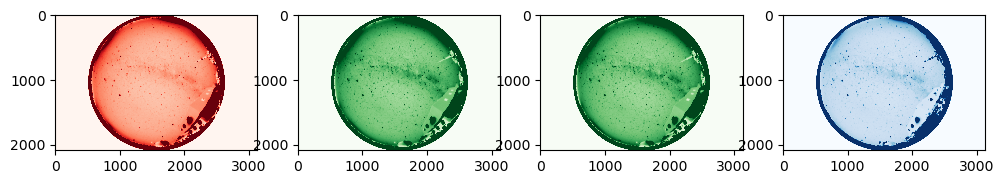

In [7]:
vmin , vmax = 0 , 900
fig,ax = plt.subplots(1,4,figsize=(12,6))
ax[0].imshow(R1,cmap='Reds',vmin=vmin,vmax=vmax)
ax[1].imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
ax[2].imshow(G3,cmap='Greens',vmin=vmin,vmax=vmax)
ax[3].imshow(B4,cmap='Blues',vmin=vmin,vmax=vmax)

#### Read the result of coordinate transformation
<pre>
The asdf file contents the WCS astrometry transformation.
The WCS transform from pixel X,Y to RA & DEC
</pre>

In [8]:
# RA & DEC  GWCS 
ofile = ipath+ifile.replace('.CR2','_wcs.asdf')  # the wcs obtained with the astrometry procedure
asdf_file = asdf.open(ofile)
print('Using WCS astrometry after calibration ', ofile)
# WCS transform in RA & DEC
gwcs_radec = asdf_file.tree['wcs']

## filetab contains the star catalog saved after calibration
filetab = ipath+ifile.replace('.CR2','_coords.csv')
print('Reading catalog RA,DEC and X,Y table   ', filetab, ' to an astropy Table')
tab = Table.read(filetab)

print(azalt_frame)
# AZ & ALT  GWCS 
tab_radec = SkyCoord(tab['index_ra'], tab['index_dec'], unit=(u.deg, u.deg),frame='icrs')
xy = ((tab['field_x'],tab['field_y']))
rd0 = SkyCoord(0., 90.,unit='deg',frame='icrs')
tab_altaz = tab_radec.transform_to(azalt_frame)
gwcs_azalt = wcs_from_points(xy, tab_altaz, proj_point=rd0,\
                             projection=Sky2Pix_ZEA(),poly_degree=6, polynomial_type='polynomial')

Using WCS astrometry after calibration  ./IMG_9467_wcs.asdf
Reading catalog RA,DEC and X,Y table    ./IMG_9467_coords.csv  to an astropy Table
<AltAz Frame (obstime=2023-10-11 22:13:56, location=(4678588.82787972, 11431.97186664, 4324584.42528495) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)>


In [9]:
G2.shape
xc = int(G2.shape[1]/2)
yc = int(G2.shape[0]/2)

### Grid of az&alt regions

1573.1821478504542 487.5447703085566


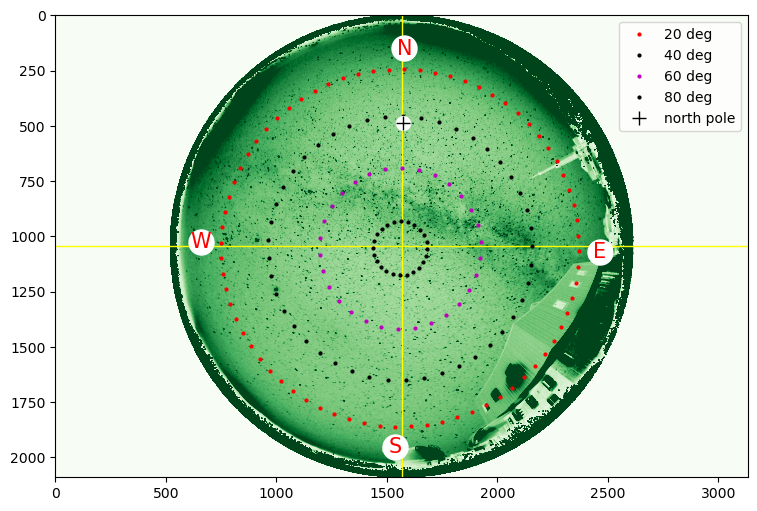

In [29]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
plt.axvline(xc,lw=1,color='yellow')
plt.axhline(yc,lw=1,color='yellow')
caz  = np.arange(0,360,5)   # [0,90,180,270]
calt = [20] * len(caz)
xd,yd = gwcs_azalt.backward_transform(caz, calt)
plt.plot(xd,yd,'ro',ms = 2,label='20 deg')
caz  = np.arange(0,360,8)  
calt = [40] * len(caz)
xd,yd = gwcs_azalt.backward_transform(caz, calt)
plt.plot(xd,yd,'ko',ms = 2,label='40 deg')
caz  = np.arange(0,360,12)  
calt = [60] * len(caz)
xd,yd = gwcs_azalt.backward_transform(caz, calt)
plt.plot(xd,yd,'mo',ms = 2,label='60 deg')
caz  = np.arange(0,360,15)  
calt = [80] * len(caz)
xd,yd = gwcs_azalt.backward_transform(caz, calt)
plt.plot(xd,yd,'ko',ms = 2,label='80 deg')

xo,yo = gwcs_radec.backward_transform(0, 90)
print(xo,yo)
plt.plot(xo,yo,'wo',ms=10)
plt.plot(xo,yo,'k+',ms=10,label='north pole')
plt.legend()

caz = [0,90,180,270]
calt = [10,10,10,10]
direction = ['N','W','S','E']
xd,yd = gwcs_azalt.backward_transform(caz, calt)
for i in range(4): 
    ax.plot(xd[i], yd[i], 'wo',ms=18)
    ax.text(xd[i], yd[i], direction[i], ha='center', va='center',color='red',fontsize=15)

plt.savefig('fig_az-alt_grid.png')

### Sampling grid test

In [13]:
alt = [5.0, 11.0, 14.0, 15.0, 14.0, 11.0, 5.0, 9.0, 18.0, 24.0, 28.0, 29.0, 28.0, 24.0, 18.0, 9.0, 9.0, 20.0, 29.0, 36.0, 41.0, 42.0, 41.0, 36.0, 29.0, 20.0, 9.0, 5.0, 18.0, 29.0, 39.0, 47.0, 53.0, 55.0, 53.0, 47.0, 39.0, 29.0, 18.0, 5.0, 11.0, 24.0, 36.0, 47.0, 57.0, 64.0, 67.0, 64.0, 57.0, 47.0, 36.0, 24.0, 11.0, 14.0, 28.0, 41.0, 53.0, 64.0, 74.0, 78.0, 74.0, 64.0, 53.0, 41.0, 28.0, 14.0, 0.0, 15.0, 29.0, 42.0, 55.0, 67.0, 78.0, 90.0, 78.0, 67.0, 55.0, 42.0, 29.0, 15.0, 0.0, 14.0, 28.0, 41.0, 53.0, 64.0, 74.0, 78.0, 74.0, 64.0, 53.0, 41.0, 28.0, 14.0, 11.0, 24.0, 36.0, 47.0, 57.0, 64.0, 67.0, 64.0, 57.0, 47.0, 36.0, 24.0, 11.0, 5.0, 18.0, 29.0, 39.0, 47.0, 53.0, 55.0, 53.0, 47.0, 39.0, 29.0, 18.0, 5.0, 9.0, 20.0, 29.0, 36.0, 41.0, 42.0, 41.0, 36.0, 29.0, 20.0, 9.0, 9.0, 18.0, 24.0, 28.0, 29.0, 28.0, 24.0, 18.0, 9.0, 5.0, 11.0, 14.0, 15.0, 14.0, 11.0, 5.0, 0.0]
azi = [207.0, 198.0, 189.0, 180.0, 171.0, 162.0, 153.0, 141.0, 149.0, 158.0, 169.0, 180.0, 191.0, 202.0, 211.0, 219.0, 231.0, 225.0, 217.0, 207.0, 194.0, 180.0, 166.0, 153.0, 143.0, 135.0, 129.0, 117.0, 121.0, 127.0, 135.0, 146.0, 162.0, 180.0, 198.0, 214.0, 225.0, 233.0, 239.0, 243.0, 252.0, 248.0, 243.0, 236.0, 225.0, 207.0, 180.0, 153.0, 135.0, 124.0, 117.0, 112.0, 108.0, 99.0, 101.0, 104.0, 108.0, 117.0, 135.0, 180.0, 225.0, 243.0, 252.0, 256.0, 259.0, 261.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 0.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 81.0, 79.0, 76.0, 72.0, 63.0, 45.0, 0.0, 315.0, 297.0, 288.0, 284.0, 281.0, 279.0, 288.0, 292.0, 297.0, 304.0, 315.0, 333.0, 0.0, 27.0, 45.0, 56.0, 63.0, 68.0, 72.0, 63.0, 59.0, 53.0, 45.0, 34.0, 18.0, 0.0, 342.0, 326.0, 315.0, 307.0, 301.0, 297.0, 309.0, 315.0, 323.0, 333.0, 346.0, 0.0, 14.0, 27.0, 37.0, 45.0, 51.0, 39.0, 31.0, 22.0, 11.0, 0.0, 349.0, 338.0, 329.0, 321.0, 333.0, 342.0, 351.0, 0.0, 9.0, 18.0, 27.0, 0.0]
print(len(azi),alt[0])

148 5.0


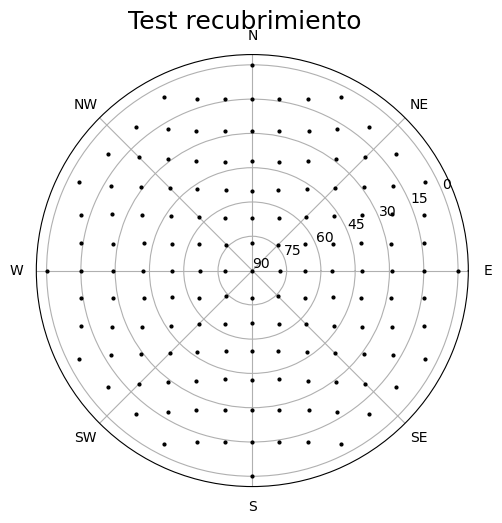

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.03, 0.15, 0.95, 0.72], polar=True) #, axisbg='#d5de9c')
plt.grid(True)

ring_angles = [ (x+0.000001) * (np.pi/180.) for x in range(0,100,15)]
ring_labels = [ str(x) for x in range(0,100,15)]
ring_labels.reverse()
lines,labels = plt.rgrids(ring_angles,ring_labels)
angles,labels = plt.thetagrids( range(360,0,-45), ( 'E', 'SE', 'S', 'SW', 'W','NW', 'N', 'NE') )

label = u"Test recubrimiento"
ax.text(1.6,1.85, label, fontsize=18, horizontalalignment='center')

# adding a missiong point
alto = 0.
azio = 180.
azi.append(azio)
alt.append(alto)
xxn=[]
yyn=[]
for i in range (0,len(azi)):
     dummy= np.pi * (azi[i]) / 180.  
     xxn.append(2* np.pi - dummy - (np.pi /2.)) 
     yyn.append((90.-alt[i]) *np.pi/180.)

#plt.plot(xxn,yyn,'k-')
plt.plot(xxn,yyn,'ko',ms=2)


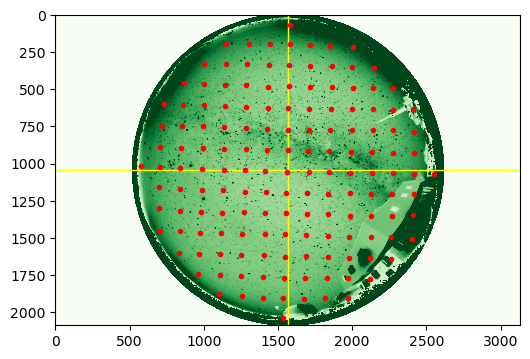

In [30]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
plt.axvline(xc,lw=1,color='yellow')
plt.axhline(yc,lw=1,color='yellow')
for i in range(len(azi)):
    xd,yd = gwcs_azalt.backward_transform(azi[i], alt[i])
    plt.plot(xd,yd,'ro',ms = 3)
plt.savefig('fig_grid_positions.png')

#### Mean value at grid points

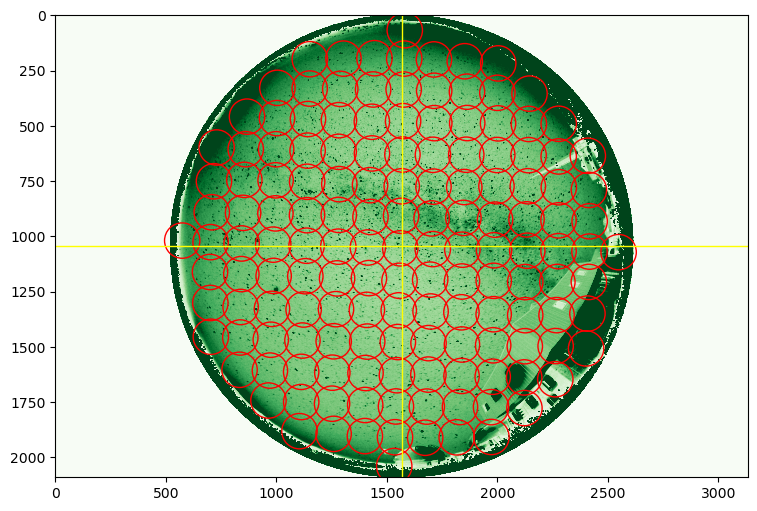

In [31]:
positions = []
radius = 80
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
plt.axvline(xc,lw=1,color='yellow')
plt.axhline(yc,lw=1,color='yellow')
for i in range(len(azi)):
    xd,yd = gwcs_azalt.backward_transform(azi[i], alt[i])
    positions.append((xd,yd))
apertures_star = CircularAperture(positions, r=radius)
apertures_star.plot(color='red', lw=1);
tbl_phot = aperture_photometry(data = G2.data, apertures=apertures_star)
tbl_phot['aperture_sum'].info.format = '.2f'
sb = (tbl_phot['aperture_sum']/texpo) /1000

plt.savefig('fig_grid_apertures.png')

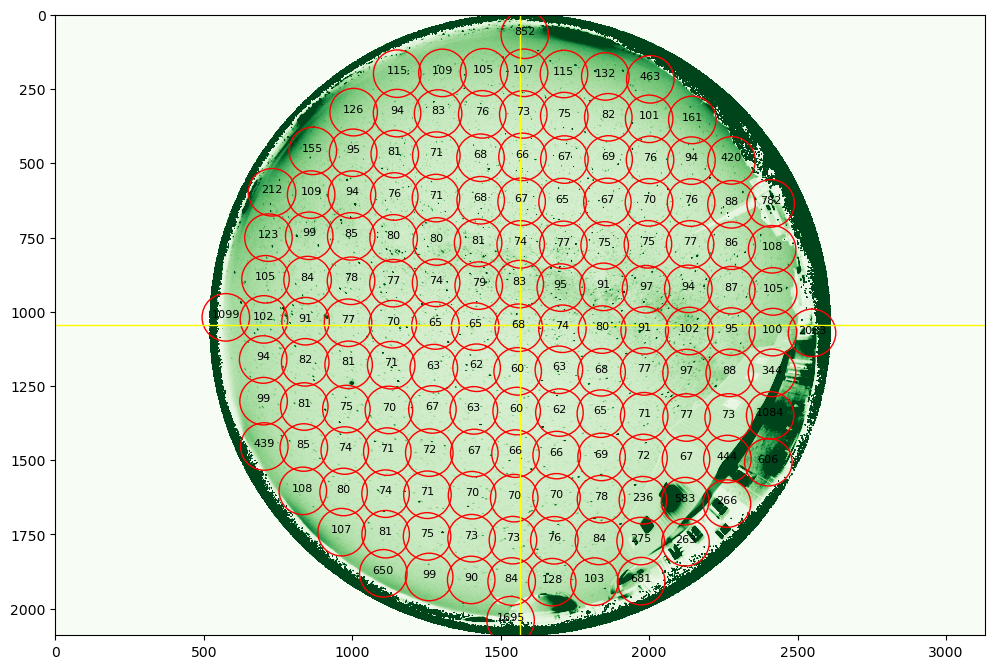

In [32]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax*2)
plt.axvline(xc,lw=1,color='yellow')
plt.axhline(yc,lw=1,color='yellow')
apertures_star.plot(color='red', lw=1);
for i in range(len(tbl_phot)):
    plt.text(positions[i][0],positions[i][1],str(int(sb[i])),ha='center',fontsize=8)

plt.savefig('fig_grid_fluxes.png')

(array([131.,   8.,   3.,   3.,   0.,   2.,   0.,   0.,   1.,   1.]),
 array([ 0.60590361,  2.62858274,  4.65126188,  6.67394101,  8.69662014,
        10.71929927, 12.74197841, 14.76465754, 16.78733667, 18.81001581,
        20.83269494]),
 <BarContainer object of 10 artists>)

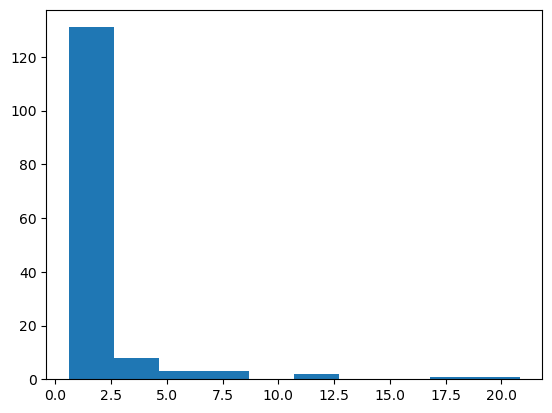

In [18]:
plt.hist(sb/100)

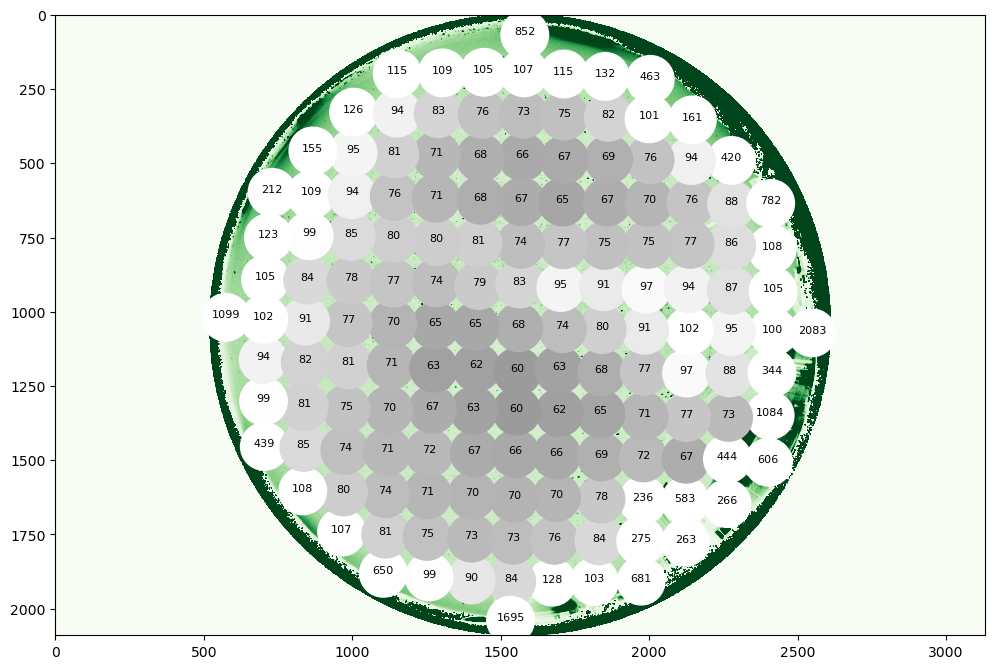

In [33]:
cms = plt.matplotlib.cm

fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax*2)
#plt.axvline(xc,lw=1,color='yellow')
#plt.axhline(yc,lw=1,color='yellow')
#apertures_star.plot(color='red', lw=1);
for i in range(len(tbl_phot)):
    plt.text(positions[i][0],positions[i][1],str(int(sb[i])),ha='center',fontsize=8)
    color = cms.gray(sb[i]/100) 
    circle = plt.Circle((positions[i][0],positions[i][1]), radius, color=color) 
    ax.add_artist(circle)  

plt.savefig('fig_grid_fluxes-colors.png')

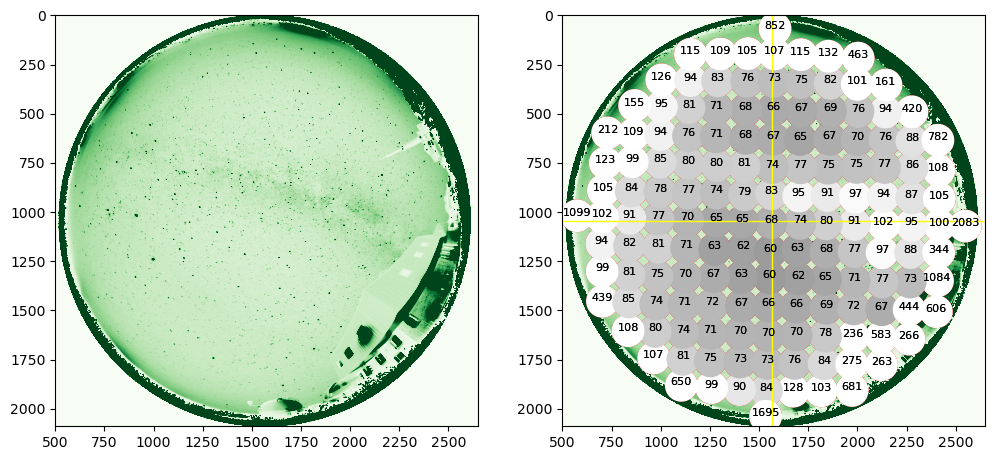

In [34]:
fig,ax = plt.subplots(1,2,figsize=(12,9))
ax[0].imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax*2)
plt.axvline(xc,lw=1,color='yellow')
plt.axhline(yc,lw=1,color='yellow')
apertures_star.plot(color='red', lw=1);
for i in range(len(tbl_phot)):
    plt.text(positions[i][0],positions[i][1],str(int(sb[i])),ha='center',fontsize=8)
ax[0].set_xlim(500,2650)
ax[1].imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax*2)
for i in range(len(tbl_phot)):
    ax[1].text(positions[i][0],positions[i][1],str(int(sb[i])),ha='center',fontsize=8)
    color = cms.gray(sb[i]/100) 
    circle = plt.Circle((positions[i][0],positions[i][1]), radius, color=color) 
    ax[1].add_artist(circle)  
ax[1].set_xlim(500,2650)

plt.savefig('fig_grid_fluxes+colors.png')

#### Contour plots

**ESTA ES LA PARTE QUE QUIERO QUE HAGA RAFAEL**

# HASTA AQUI

### Photometry zero points
<pre>
    Previously obtained during the photometry step.
    Inserted here but ToDo --> create a file with the photometry results
</pre>

In [37]:
# stars 20 deg up   zenit angele z<70
#   zero point      extinction coeff   color term
# B 10.93 +/- 0.06    0.48 +/- 0.04    -0.12 +/- 0.04
# G 11.11 +/- 0.06    0.41 +/- 0.04    -0.1 +/- 0.07
# R 10.0 +/- 0.06    0.37 +/- 0.04    0.0 +/- 0.06
zpB = 10.93
zpG = 11.11
zpR = 10.0
expo = 120.2

In [61]:
fvalue = 716.5193798435873
# variable escale along the zenit angle
#ydr = np.rad2deg(1./(2098/2*np.cos(zen/2.)))*3600.
#ydl = np.rad2deg(1./(2098 *np.sin(zen/2.)))*3600.
#domega = np.sin(zen)*ydr*ydl*np.pi/180. ## = 38683 *pi/180
# fixed escale (ZEA ?)
#fvalue = 2098
ydr = np.rad2deg(1./(fvalue/2*np.cos(0.01/2.)))*3600.
ydl = np.rad2deg(1./(fvalue *np.sin(0.01/2.)))*3600.
#ydr = np.rad2deg(1./(fvalue/2))*3600.
#ydl = np.rad2deg(1./(fvalue))*3600.
print(ydr,ydl)
domega = np.sin(0.1)*ydr*ydl*np.pi/180. ## = 38683 *pi/180
#domega = ydr*ydl*np.pi/180. 
print(domega)

575.748236227914 57574.343831794904
57758.36824261549


945 1145 1416 1716
420.9722396948737 60000 3.5022648893084334
9.749127524261922
57758.36824261549 arsec2/pixel 11.90403728822017 NSB G zenit 21.653164812482093


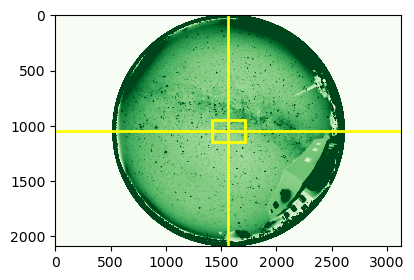

In [62]:
vmin , vmax = 0 , 900
fig,ax = plt.subplots(1,1,figsize=(6,3))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
plt.axvline(xc,lw=2,color='yellow')
plt.axhline(yc,lw=2,color='yellow')
sizex , sizey = 300 , 200
x1 = xc - int(sizex / 2)
x2 = xc + int(sizex / 2)
y1 = yc - int(sizey / 2)
y2 = yc + int(sizey / 2)
ax.add_patch(plt.Rectangle((x1, y1), sizex, sizey, ls="-", ec="yellow", lw=2,fc="none"))
media = np.mean(G2[y1:y2,x1:x2])
print(y1,y2,x1,x2)
area = (x2 -x1) * (y2-y1)
print(media, area , media/ texpo)
m = zpG - 2.5 * np.log10(media/texpo)
print(m)

# escala aproximada:
#escale =  180 * 3600 / G2.shape[0] 
#print(G2.shape[0],escale, 'arcsec/pixel')
#factor = escale * escale

print(domega,'arsec2/pixel',2.5*np.log10(domega),'NSB G zenit',m+2.5*np.log10(domega))

#### Checking ZEA equal area
The domega (pixel escale) should be independent of zenithal angle

In [90]:
fvalue = 716.5193798435873

print(G2.shape,G2.shape[0],G2.shape[1])
nxpix = G2.shape[0]
nypix = G2.shape[1]
img_nx = np.arange(nxpix)
img_ny = np.arange(nypix)
img_x, img_y = np.meshgrid(img_ny,img_nx)

f_gaz, f_galt = gwcs_azalt(img_x,img_y)
id0 = (f_galt < 0) | (np.isnan(f_galt))

zen = np.deg2rad(90.-f_galt)
zen[id0] = 1
rdis = np.sqrt((img_x-nxpix/2)**2.+(img_y-nypix/2)**2.)
#print(rdis)

ydl = np.rad2deg(1./(fvalue *np.sin(zen/2.)))*3600.
domega = np.sin(zen)*ydr*ydl*np.pi/180. ## = 38683 *pi/180
#print(domega)
#hdu = fits.PrimaryHDU(domega)
#hdu.writeto(cpath+'omega.fits',overwrite=True)

(2090, 3132) 2090 3132


In [91]:
fvalue = 716.5193798435873
# variable escale along the zenit angle
#ydr = np.rad2deg(1./(2098/2*np.cos(zen/2.)))*3600.
#ydl = np.rad2deg(1./(2098 *np.sin(zen/2.)))*3600.
#domega = np.sin(zen)*ydr*ydl*np.pi/180. ## = 38683 *pi/180
# fixed escale (ZEA ?)
#fvalue = 2098
ydr = np.rad2deg(1./(fvalue/2*np.cos(0.01/2.)))*3600.
ydl = np.rad2deg(1./(fvalue *np.sin(0.01/2.)))*3600.
#ydr = np.rad2deg(1./(fvalue/2))*3600.
#ydl = np.rad2deg(1./(fvalue))*3600.
print(ydr,ydl)
domega = np.sin(0.1)*ydr*ydl*np.pi/180. ## = 38683 *pi/180
#domega = ydr*ydl*np.pi/180. 
print(domega)

575.748236227914 57574.343831794904
57758.36824261549


In [92]:
bn = zpG - 2.5*np.log10(G2/domega/texpo)
print(bn.shape)
print(id0)
#bn[f_galt<10] = 19
bn[bn>22] = 22
bn[id0] = 19

(2090, 3132)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


/var/folders/8d/2bcbltss6ll32_vkykfqr14c0000gp/T/ipykernel_67310/3764984208.py:1: RuntimeWarning: divide by zero encountered in log10
  bn = zpG - 2.5*np.log10(G2/domega/texpo)


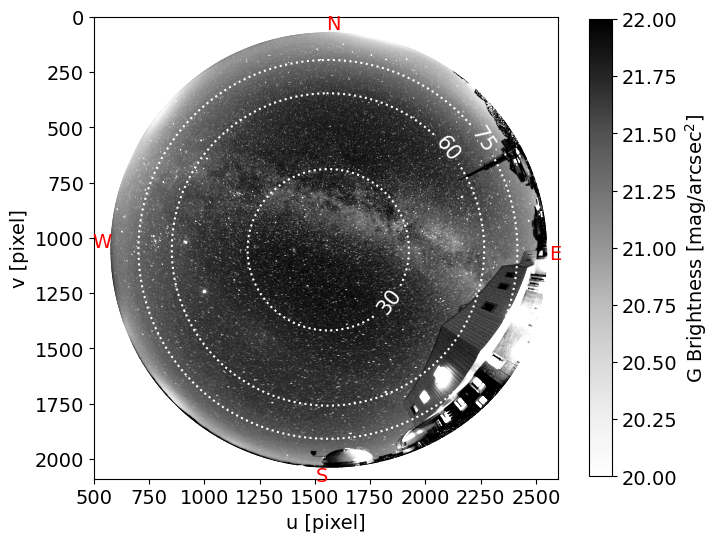

In [109]:
# show the sky brightness in G band
caz = [0,90,180,270]
calt = [-5,-5,-5,-5]
direction = ['N','W','S','E']
xd,yd = gwcs_azalt.backward_transform(caz, calt)

fsize=14
fig, ax = plt.subplots(ncols=1,figsize=(8,6),dpi=100)
im = ax.imshow(bn,cmap='Grays',vmin=20,vmax=22)
ax.set_xlabel('u [pixel]',fontdict={'size':fsize})
ax.set_ylabel('v [pixel]',fontdict={'size':fsize})
C = ax.contour(img_x, img_y, 90-f_galt, levels=[30.,60.,75.], colors='w',linestyles=':')
ax.clabel(C, inline=1, fontsize=15)
for i in range(4): 
    ax.text(xd[i], yd[i], direction[i], ha='center', va='center',color='red',fontsize=fsize)
cbar = fig.colorbar(im,shrink=0.99,ax=ax)
cbar.set_label('G Brightness [mag/arcsec$^2$]',fontdict={'size':14}) 
cbar.ax.tick_params(labelsize=14)
plt.xticks(size=fsize)
plt.yticks(size=fsize)
#plt.savefig(ipath+'xbrightness.png', dpi=300, bbox_inches='tight',facecolor='white') 
plt.xlim(500,2600)
plt.savefig('fig_NSB_G.png')